In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import functools
import networkx as nx
from datetime import date, timedelta
from datetime import datetime
from scipy.ndimage import gaussian_filter1d

#sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
#sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/joshuakeeling/Documents/Python/Project/line_loop/packages/")

In [6]:
import mouse_poker as mpk
from mouse_poker.navi import *

In [7]:
def performance_arrays(state_seq,port_seq,rew_list,forced_seq):
    
    """
    Find the state being rewarded during each step in the session
    If the choice that is made decreases the step distance from rew
    score choice as correct (1) if not, score as incorrect (0)
    
    Creates some useful arrays: 
    state_seq,rew_list,port_seq,forced_seq,rew_state,score_list,
    rew_change,rew_change_end,trial_perf,trial_rew_change_end
    """
    
    ##Need to end the used data with the final reward rather than 
    #half way through a trial
    #take out forced trials
    final = np.where(rew_list)[0][-1]+1
    state_seq = state_seq[0:final]
    rew_list = rew_list[0:final]
    port_seq = port_seq[0:final]
    forced_seq = forced_seq[0:final]    
    
    ##Create array of state being rewarded during each step in the session
    rew_state = np.zeros(len(rew_list))
    prev_rew_ind = 0
    for rew_ind in np.where(rew_list)[0]:
        rew_state[prev_rew_ind:rew_ind+1]=state_seq[rew_ind]
        prev_rew_ind = rew_ind+1

    #Whether the choice is correct:
    score_list = np.zeros(len(rew_list))

    for state_ind in np.arange(len(state_seq)):
        if rew_list[state_ind] is True:
            score_list[state_ind] = 'Nan' #Score the reward state "choice" as Nan
        else:
            d0 = np.abs(state_seq[state_ind]-rew_state[state_ind])
            d1 = np.abs(state_seq[state_ind+1]-rew_state[state_ind+1])
            if d1 - d0 == -1:
                #correct choice gets score of 1
                score_list[state_ind]=1
            else:
                #incorrect choice gets score of 0
                score_list[state_ind]=0
    
    ##Remove forced choices from performance scores
    score_list[np.where(forced_seq)[0]]='Nan'
    
    ##Remove end of line choices from performance scores if "line"
    if mpk.load.get_metadata(lines)[5]=='line':
        ind = np.where((np.array(state_seq)==min(state_seq))|(np.array(state_seq)==max(state_seq)))[0]
        score_list[ind]='Nan'
        
    ##Arr for indices of reward changes (rew is in new loc after this index)
    rew_change = np.where(rew_state[:-1] != rew_state[1:])[0]
    #Ensure analysis of final section
    rew_change_end = np.append(rew_change, len(rew_list)-1) #could take out if final trial is not useful
    #rew_change_end = rew_change
    
    ## Arr of perf with each successive trial
    # trial_perf
    rew_ind = np.where(rew_list)[0]
    trial_perf = [] #Arr w perf on each trial scored as above
    trial_dec_count = [] #Arr w num decisions on each trial
    low1 = -1
    low2 = 0
    
    for rew_change_ind in rew_change_end:
        #Create arrays for score + number of decisions for each trial
        for trial_ind in np.where((rew_ind>low1) & (rew_ind<=rew_change_ind))[0]:
            upp = int(rew_ind[trial_ind])
            score = np.nanmean(score_list[low2:upp])
            count = np.sum(~np.isnan(score_list[low2:upp]))
            low2 = int(rew_ind[trial_ind])
            trial_perf.append(score)
            trial_dec_count.append(count)
        low1 = rew_change_ind

        
    ##Create arr for trial# where rew change
    # trial_rew_change_end
    trial_rew_change_end = np.zeros(len(rew_change_end))
    for rew_change_step in np.arange(len(rew_change_end)):
        y = np.where(np.where(rew_list)[0]==rew_change_end[rew_change_step])[0]
        trial_rew_change_end[rew_change_step] = y

    return state_seq,rew_list,port_seq,forced_seq,rew_state,score_list,\
    rew_change,rew_change_end,trial_perf,trial_rew_change_end,trial_dec_count


def get_poke_to_state_map(lines):
    """ """
    tmp = []
    for i,j in zip([int(re.findall('POKEDPORT_([0-9])',i)[0]) for i in lines if '_POKEDPORT' in i],
                         [int(re.findall('POKEDSTATE_([0-9])',i)[0]) for i in lines if '_POKEDSTATE' in i]):

        if [i,j] not in tmp:
            tmp.append([i,j])
    poke_to_state_map = [i[1] for i in sorted(tmp)]
    return poke_to_state_map

In [8]:
##BATCH ANALYSIS:

#ROOT = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_3NAVI/'
ROOT = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_4_RUNNAVI/'

res_dict = {}
minNrew = 100
today = datetime.now()

files = []
DF = pd.DataFrame()

for filename in os.listdir(ROOT):
    if filename.endswith(".txt"): 
        files.append(filename)
    else:
        continue

for file in files:
    
    fpath = os.path.join(ROOT, file)
    f = open(fpath, 'r')
    lines = f.readlines()
    
    #Get metadata:
    experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,\
        test,overview = mpk.load.get_metadata(lines)
    
    
    if overview['n_rewards'] > minNrew:
        
        state_seq,rew_list,port_seq,forced_seq = extract_navi_dat(lines)

        state_seq,rew_list,port_seq,forced_seq,rew_state,score_list,\
            rew_change,rew_change_end,trial_perf,trial_rew_change_end,trial_dec_count\
            = performance_arrays(state_seq,port_seq,rew_list,forced_seq)
        
        poke_state_map = get_poke_to_state_map(lines)
   
        file_dict = {'subject_id':subject_id,'date_time':pd.to_datetime(date),\
                'state_seq':state_seq,'rew_list':rew_list,'port_seq':port_seq,\
                'forced_seq':forced_seq,'rew_state':rew_state,'score_list':score_list,\
                'rew_change':rew_change,'rew_change_end':rew_change_end,\
                'trial_perf':trial_perf,'trial_rew_change_end':trial_rew_change_end,\
                'poke_state_map':poke_state_map,'trial_dec_count':trial_dec_count}

        DF = DF.append(file_dict, ignore_index = True)
    
        mean_perf = np.nanmean(score_list)

        print(mpk.load.get_metadata(lines)[5], int(100*mean_perf), file)

line 78 '456675_3'-2021-03-02-103339.txt
line 68 '456675_3'-2021-02-15-113953.txt
line 70 '456675_3'-2021-02-23-102808.txt
line 69 '456675_3'-2021-02-25-110427.txt


<ipython-input-7-14473cb5e387>:71: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score_list[low2:upp])


line 56 '456675_3'-2021-03-05-120244.txt
line 69 '456675_3'-2021-03-01-110336.txt
line 79 '456675_3'-2021-03-04-105909.txt
line 69 '456675_3'-2021-02-12-121633.txt
line 82 '456675_3'-2021-03-03-105842.txt
line 65 '456675_3'-2021-02-11-122740.txt
line 76 '456675_3'-2021-02-26-104433.txt


In [9]:
#Performance in each state for a given reward location

min_state = np.min(DF['state_seq'][0]) #uses values from the first session for all sessions
max_state = np.max(DF['state_seq'][0]) #uses values from the first session for all sessions
rew_locs = (np.unique(DF['rew_state'][0])).astype(int) #uses values from the first session for all sessions 

Ncols = len(np.arange(min_state,max_state+1,1))
Nrows = len(np.unique(rew_locs))
Nsess = len(np.arange(np.shape(DF)[0]))

score_matrix = np.zeros((Nsess,Nrows,Ncols))
count_matrix = np.zeros((Nsess,Nrows,Ncols))

for sess in np.arange(np.shape(DF)[0]):
    STATE = DF['state_seq'][sess]
    SCORE = DF['score_list'][sess]
    REW_LOC = (DF['rew_state'][sess]).astype(int)
    
    for col in np.arange(min_state,max_state+1,1):
        for rew_loc in rew_locs:
            
            score_sum = np.nansum(((SCORE[np.where((np.array(STATE)==col)&(np.array(REW_LOC)==rew_loc))[0]])))
            count = sum(~np.isnan(SCORE[np.where((np.array(STATE)==col)&(np.array(REW_LOC)==rew_loc))[0]]))
            row = np.where(rew_locs==rew_loc)[0]
            score_matrix[sess,row,col] = score_sum
            count_matrix[sess,row,col] = count
            
score_matrix = np.sum(score_matrix, axis = 0)/np.sum(count_matrix, axis = 0)

<ipython-input-9-caa6935def0a>:28: RuntimeWarning: invalid value encountered in true_divide
  score_matrix = np.sum(score_matrix, axis = 0)/np.sum(count_matrix, axis = 0)


In [10]:
#Need to work out logic gate for trial selection
#IF N is the trial with a new reward location (rew location is discovered this trial)
#need to look at N + 1 and see if the mouse goes towards the old rew location or the new one
#can only test this when on trial N+1 the mouse is started between the old and new rew location in state space

#need trial where rew change loc

In [21]:
DF

,date_time,forced_seq,poke_state_map,port_seq,rew_change,rew_change_end,rew_list,rew_state,score_list,state_seq,subject_id,trial_dec_count,trial_perf,trial_rew_change_end
0,2021-03-02 10:33:39,"[True, False, False, False, False, False, Fals...","[5, 2, 0, 3, 4, 7, 6, 8, 1]","[7, 5, 6, 0, 4, 3, 1, 3, 1, 8, None, 3, 1, 3, ...","[162, 450, 548, 676, 834, 998, 1106, 1294, 144...","[162, 450, 548, 676, 834, 998, 1106, 1294, 144...","[False, False, False, False, False, False, Fal...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...","[8, 7, 6, 5, 4, 3, 2, 3, 2, 1, 4, 3, 2, 3, 2, ...",456675_3,"[8, 16, 13, 5, 8, 4, 4, 6, 3, 5, 9, 8, 2, 5, 6...","[0.875, 0.4375, 0.6153846153846154, 1.0, 0.75,...","[20.0, 43.0, 68.0, 89.0, 119.0, 140.0, 162.0, ..."
1,2021-02-15 11:39:53,"[False, False, False, False, False, False, Tru...","[5, 2, 0, 3, 4, 7, 6, 8, 1]","[4, 0, 4, 0, 6, 5, 7, 5, 6, 0, 6, 0, 4, 3, 4, ...","[336, 602, 707, 965]","[336, 602, 707, 965, 1081]","[False, False, False, False, False, False, Fal...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, nan, 1.0, 1.0, ...","[4, 5, 4, 5, 6, 7, 8, 7, 6, 5, 6, 5, 4, 3, 4, ...",456675_3,"[13, 12, 11, 16, 10, 2, 13, 11, 3, 11, 11, 11,...","[0.46153846153846156, 0.3333333333333333, 0.45...","[25.0, 46.0, 67.0, 89.0, 111.0]"
2,2021-02-23 10:28:08,"[False, False, False, False, False, False, Fal...","[5, 2, 0, 3, 4, 7, 6, 8, 1]","[0, 4, 0, 6, 0, 4, 0, 4, 0, 4, 0, 4, 3, None, ...","[184, 428, 653, 754, 982, 1204]","[184, 428, 653, 754, 982, 1204, 1404]","[False, False, False, False, False, False, Fal...","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[5, 4, 5, 6, 5, 4, 5, 4, 5, 4, 5, 4, 3, 1, 0, ...",456675_3,"[12, 4, 2, 2, 2, 2, 2, 5, 6, 3, 5, 4, 4, 6, 2,...","[0.5833333333333334, 0.5, 1.0, 1.0, 1.0, 1.0, ...","[32.0, 53.0, 80.0, 101.0, 128.0, 150.0, 166.0]"
3,2021-02-25 11:04:27,"[False, False, False, False, True, False, Fals...","[5, 2, 0, 3, 4, 7, 6, 8, 1]","[1, 3, 1, 8, 2, 8, 1, 3, 1, 8, 1, 3, 1, 3, 4, ...","[323, 517, 752, 866, 1033]","[323, 517, 752, 866, 1033, 1239]","[False, False, False, False, False, False, Fal...","[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...","[1.0, 0.0, 0.0, 0.0, nan, 1.0, 1.0, 0.0, 0.0, ...","[2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 2, 3, 2, 3, 4, ...",456675_3,"[14, 9, 14, 13, 8, 4, 13, 15, 12, 10, 11, 14, ...","[0.5714285714285714, 0.6666666666666666, 0.714...","[20.0, 41.0, 62.0, 83.0, 104.0, 119.0]"
4,2021-03-05 12:02:44,"[False, False, False, False, False, False, Fal...","[5, 2, 8, 3, 6, 7, 4, 0, 1]","[3, None, 4, 0, 4, 0, 6, 3, None, 6, 3, None, ...","[128, 504, 723, 1032, 1499, 1716]","[128, 504, 723, 1032, 1499, 1716, 1798]","[True, False, False, False, False, False, Fals...","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[nan, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, nan, 1.0, ...","[3, 7, 6, 5, 6, 5, 4, 3, 5, 4, 3, 0, 1, 2, 3, ...",456675_3,"[0, 6, 2, 2, 4, 5, 3, 2, 6, 2, 3, 2, 2, 6, 9, ...","[nan, 0.8333333333333334, 1.0, 1.0, 0.75, 0.8,...","[22.0, 43.0, 65.0, 91.0, 116.0, 138.0, 142.0]"
5,2021-03-01 11:03:36,"[False, False, False, False, False, False, Fal...","[5, 2, 0, 3, 4, 7, 6, 8, 1]","[8, None, 1, 3, 1, 3, 1, 3, 4, 0, 6, 0, 4, 0, ...","[193, 323, 549, 890]","[193, 323, 549, 890, 1010]","[True, False, False, False, False, False, Fals...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1, 3, 2, 3, 2, 3, 2, 3, 4, 5, 6, 5, 4, 5, 4, ...",456675_3,"[0, 16, 13, 3, 12, 6, 7, 6, 4, 12, 3, 7, 8, 7,...","[nan, 0.5, 0.46153846153846156, 1.0, 0.5833333...","[20.0, 42.0, 72.0, 96.0, 117.0]"
6,2021-03-04 10:59:09,"[True, False, False, False, False, False, Fals...","[5, 2, 0, 3, 4, 7, 6, 8, 1]","[2, 8, 1, 3, None, 6, 0, 4, 3, None, 5, 6, 0, ...","[191, 326, 437, 611, 738, 993, 1091, 1230, 133...","[191, 326, 437, 611, 738, 993, 1091, 1230, 133...","[False, False, False, Tr

In [209]:
x = 459
z = 5

In [210]:
list(zip(DF['score_list'][index][x-z:x+z],DF['state_seq'][index][x-z:x+z],DF['rew_state'][index][x-z:x+z]))


[(nan, 8, 3.0),
 (1.0, 7, 3.0),
 (1.0, 6, 3.0),
 (1.0, 5, 3.0),
 (1.0, 4, 3.0),
 (nan, 3, 3.0),
 (0.0, 5, 3.0),
 (1.0, 6, 3.0),
 (1.0, 5, 3.0),
 (1.0, 4, 3.0)]

In [185]:
change_I = np.where(DF['rew_list'][index])[0][int(rew_change)]

plus1_I = np.where(DF['rew_list'][index])[0][int(rew_change)+1]

In [225]:
score_arr = []

In [233]:
score_arr.append(score_val)

In [234]:
score_arr

[1, 1, 1, 1.0]

In [232]:
score_val

1.0

In [274]:
#Trial rew change gives the trial before reward is moved
#we want the decision after the trial after rew changes so we want the decision after trial +1 
score_df = pd.DataFrame()
for index in DF.index:
    score_arr = []
    for num, rew_change in enumerate(DF['trial_rew_change_end'][index][0:-1]): #dont use "end"
        change_I = np.where(DF['rew_list'][index])[0][int(rew_change)]
        plus1_I = np.where(DF['rew_list'][index])[0][int(rew_change)+3]


        #make logic gate for which trials are used!
        state = DF['state_seq'][index][plus1_I+1]
        old_rew = DF['rew_state'][index][change_I]
        new_rew = DF['rew_state'][index][plus1_I+1]

        if (old_rew > state > new_rew) or (old_rew < state < new_rew):
            score_val = DF['score_list'][index][plus1_I+1]
            score_arr.append(score_val)
            #print(score_val)
        else:
            continue
        #This gives the index of the reward when the end in terms of 
        #Do they go towards reward?
    
    score_df = score_df.append(score_arr)

In [275]:
np.nanmean(score_df)

0.7333333333333333

In [248]:
#Trial rew change gives the trial before reward is moved
#we want the decision after the trial after rew changes so we want the decision after trial +1 
score_df = pd.DataFrame()
score_arr = np.zeros(len(DF['trial_rew_change_end'][index][0:-1]))
for index in DF.index:
    score_arr = np.zeros(len(DF['trial_rew_change_end'][index][0:-1]))
    for num, rew_change in enumerate(DF['trial_rew_change_end'][index][0:-1]): #dont use "end"
        ind = np.where(DF['rew_list'][index])[0][int(rew_change)+1]

        #This gives the index of the reward when the end in terms of 
        #Do they go towards reward?
        score_val = DF['score_list'][index][ind+1]
        score_arr[num] = score_val

        #make logic gate for which trials are used!
        #if 
        print(ind)

    score_df = np.append(score_df,score_arr)



180
459
551
687
848
1001
1114
1297
1446
1584
358
608
729
975
205
445
657
762
1002
1225
344
539
766
879
1055
148
527
743
1051
1519
1738
210
343
570
908
195
331
448
630
757
997
1096
1233
1353
1571
333
708
923
1249
1466
1598
173
279
540
665
832
929
1170
523
719
845
1042
189
339
516
766
884
1162
1399
1575


In [130]:
np.nanmean(score_df)

0.7068965517241379

In [118]:
for num, rew_change in enumerate(DF['trial_rew_change_end'][index][0:-1]): #dont use "end"
    print(num,rew_change)

0 20.0
1 43.0
2 68.0
3 89.0
4 119.0
5 140.0
6 162.0
7 193.0
8 214.0
9 239.0


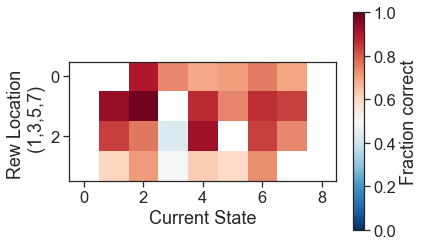

In [91]:
#Plot of performance with given reward locations

plt.imshow(score_matrix,vmin=0,vmax=1,cmap='RdBu_r')
plt.xlabel("Current State")
plt.ylabel("Rew Location \n (1,3,5,7)")
cbar = plt.colorbar()
cbar.set_label("Fraction correct")

In [ ]:
#Performance across sessions 

min_state = np.min(DF['state_seq'][0])
max_state = np.max(DF['state_seq'][0])


Ncols = len(np.arange(min_state,max_state+1,1))
Nrows = np.shape(DF)[0]
empty = np.zeros((Nrows,Ncols))

for row in np.arange(np.shape(DF)[0]):
    
    STATE = DF['state_seq'][row]
    SCORE = DF['score_list'][row]
    
    for col in np.arange(np.min(STATE),np.max(STATE)+1,1):
        y = np.nanmean(SCORE[np.where(np.array(STATE)==col)[0]])
        empty[row,col] = y


In [ ]:
#Plot of performance across sessions 

plt.imshow(empty,vmin=0,vmax=1,cmap='RdBu_r')
plt.xlabel("Current State")
plt.ylabel("Session")
cbar = plt.colorbar()
cbar.set_label("Fraction correct")

In [ ]:
##SINGLE FILE ANALYSIS

#This one for 3:
root = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_3NAVI/'
#file = "'456675_10'-2021-02-23-102809.txt"
#file = "'456675_10'-2021-03-04-105905.txt"
file = "'460175_10'-2021-03-02-142443.txt"
#file = "'460175_10'-2021-03-02-132053.txt"

# #This one for 4:
# root = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_4_RUNNAVI/'
# #file = "'456675_3'-2021-02-12-121633.txt"
# file = "'456675_3'-2021-03-02-103339.txt"

fpath = os.path.join(root,file)
f = open(fpath)
lines = f.readlines()

#Get metadata:
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,\
    test,overview = mpk.load.get_metadata(lines)

state_seq,rew_list,port_seq,forced_seq = extract_navi_dat(lines)

overview

state_seq,rew_list,port_seq,forced_seq,rew_state,score_list,\
rew_change,rew_change_end,trial_perf,trial_rew_change_end, trial_dec_count \
= performance_arrays(state_seq,port_seq,rew_list,forced_seq)

In [ ]:
new_DF = DF.sort_values('date_time')

#Plot of proportion correct decisions on cumulative trials for subsequent sessions

for i in new_DF['trial_perf']:
    
    plt.scatter(np.arange(len(i)),i,color='k',s=50,edgecolors='none')
    plt.xlabel("trial #")
    plt.ylabel("Proportion\n correct")
    plt.ylim(.1,1.1)
    seaborn.despine()
    print(np.nanmean(i))
    plt.show()

In [ ]:
for index in DF.index:

    z = 0

    print("Mean perf in each rew location")
    for i in DF.rew_change_end[index]:
        y = np.nanmean(DF.score_list[index][z:i-1])
        z = i-1
        print(DF.rew_state[index][i-1], int(y*100))

    print("\nDoes perf imprv with succ trials with rew at same loc??")
    NM = 10 #arbitrary number of sections to take mean of
    low = 0
    arr = np.linspace(rew_change[0],rew_change_end[1],num=NM)

    for i in np.arange(NM):
        upp = arr[i]
        y = np.nanmean(DF.score_list[index][int(low):int(upp)])
        low = arr[i]
        print(int(y*100))

In [ ]:
print("Plot perf in first set of rewards")
x = range(int(DF.trial_rew_change_end[index][0]-1))
y = DF.trial_perf[index][0:int(DF.trial_rew_change_end[index][0])-1]

plt.scatter(x, y,color='k',s=128,edgecolors='none')
plt.xlabel("# of successive rewards at some location")
plt.ylabel("Proportion\n correct")
plt.ylim(.1,1.1)
seaborn.despine()

Plot perf for successive trials at a reward location


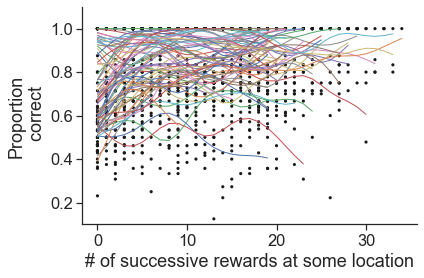

In [120]:
print("Plot perf for successive trials at a reward location")
low = 1
y_dat = pd.DataFrame()

for index in DF.index:
    y_DAT = []
    for i in np.arange(len(DF.trial_rew_change_end[index])):
        upp = int(DF.trial_rew_change_end[index][i])
        x = np.arange(upp-low)
        y = DF.trial_perf[index][low:upp]
        low = upp + 1
        y_DAT.append(y)
        plt.scatter(x, y,color='k',s=10,edgecolors='none')
        plt.xlabel("# of successive rewards at some location")
        plt.ylabel("Proportion\n correct")
        plt.ylim(0.1,1.1)
        seaborn.despine()
        plt.plot(gaussian_filter1d(y,2.25,mode='nearest'),linewidth=1)
    y_dat = y_dat.append(y_DAT)

In [121]:
y_dat

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.437500,0.615385,1.000000,0.750000,1.000000,1.000000,1.000000,1.00,1.000000,0.777778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.642857,0.500000,0.437500,0.714286,0.500000,0.538462,0.642857,1.00,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.714286,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000000,0.833333,1.000000,1.000000,0.533333,0.642857,0.833333,1.00,0.833333,0.625000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,...,0.7,1.00,0.750000,0.833333,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1.000000,1.000000,0.833333,1.000000,1.000000,1.000000,0.750000,1.00,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.500000,0.615385,0.714286,0.461538,0.750000,0.428571,0.666667,0.75,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.875000,0.666667,0.714286,1.000000,1.000000,0.833333,1.000000,1.00,1.000000,0.833333,...,1.0,0.75,0.833333,0.800000,1.0,1.0,0.857143,1.0,0.833333,NaN
7,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.80,1.000000,1.000000,...,1.0,1.00,1.000000,1.000000,1.0,1.0,0.800000,1.0,1.000000,NaN


In [ ]:
low = 1
num_correct = pd.DataFrame()
num_decisions = pd.DataFrame()

count_arr = []

for session in DF.index:
    num_corr = []
    num_dec = []
    counter = 0
    for rew_segment in np.arange(len(DF.trial_rew_change_end[session])):
        upp = int(DF.trial_rew_change_end[session][rew_segment])
        perf = DF.trial_perf[session][low:upp]
        count = DF.trial_dec_count[session][low:upp]
        correct = (np.asarray(perf))*(np.asarray(count))
        low = upp + 1
        num_corr.append(correct)
        num_dec.append(count)
        counter = counter + 1
    count_arr.append(counter)
    print(session,counter)
    score = pd.DataFrame(num_corr)/pd.DataFrame(num_dec)
    mn_score = np.nanmean(score,0)
    plt.scatter(np.arange(len(mn_score)),mn_score)
    plt.ylim(0.45,1.05)
    plt.xlim(-1,23.5)
    plt.show()
    num_correct = num_correct.append(num_corr)
    num_decisions = num_decisions.append(num_dec)

In [ ]:
mean_score = np.asarray(num_correct.sum(axis=0))/np.asarray(num_decisions.sum(axis=0))
x = np.arange(len(mean_score))

plt.scatter(x, mean_score, color='k',s=10,edgecolors='none')

plt.xlabel("# of successive rewards at some location")
plt.ylabel("Proportion \n correct")
plt.ylim(0.45,1.05)
plt.xlim(-1,23.5)
seaborn.despine()
plt.plot(gaussian_filter1d(mean_score,2.25,mode='nearest'),linewidth=1)

In [ ]:
y = np.nanmean(y_dat, 0)
x = np.arange(len(y))
plt.scatter(x, y, color='k',s=10,edgecolors='none')
plt.xlabel("# of successive rewards at some location")
plt.ylabel("Proportion correct \n (each trial counts the same)")
plt.ylim(0.45,1.05)
plt.xlim(-1,23.5)
seaborn.despine()
plt.plot(gaussian_filter1d(y,2.25,mode='nearest'),linewidth=1)

In [ ]:
print("Plot perf for each section of reward location")
low = 0
for i in np.arange(len(DF.trial_rew_change_end[index])):
    upp = int(DF.trial_rew_change_end[index][i]-1)
    x = np.arange(upp-low)
    y = DF.trial_perf[index][low:upp]
    low = upp
    
    plt.scatter(x, y,color='k',s=128,edgecolors='none')
    plt.xlabel("# of successive rewards at some location")
    plt.ylabel("Proportion\n correct")
    plt.ylim(.3,1.1)
    seaborn.despine()
    plt.show()
